# Predicting the SPY
---

- [0. Data Processing]
- [1. Neural Network]
- [2. 1D Convolution Neural Network]

The models get the following:
- normalised data
    - Neural Net: 0.251
    - Conv 1D Neural Net: 0.36
    - LSTM: 0.32


## 0. Data Processing

The data is 5min intervals.

The target variable for this will be binary. Does the SPY go up or down in the next 30min. Will ingest the last 2 hours of data as input.


In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini

In [2]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03


In [3]:
df.datetime.agg(['max','min'])

max   2022-03-25 14:10:00
min   2022-01-03 09:00:00
Name: datetime, dtype: datetime64[ns]

In [4]:
df.shape

(10965, 10)

In [5]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03,300.0,0.000609


In [6]:
# min_max = df.groupby('date')['close'].agg(['min','max']).shift(1).reset_index().rename(columns={'min':'previous_day_min',
#                                                                                                 'max':'previous_day_max'})
# df = df.merge(min_max,on='date')
# df['previous_day_max_ratio'] = df['close']/df['previous_day_max']
# df['previous_day_min_ratio'] = df['close']/df['previous_day_min']

<AxesSubplot:xlabel='datetime'>

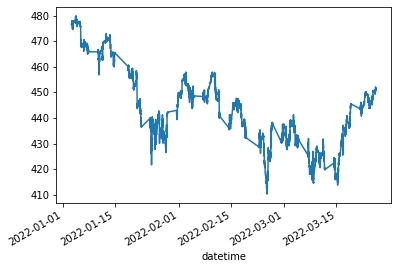

In [7]:
df.set_index('datetime')['close'].plot()

In [8]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1

10965 ticks found


In [9]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [10]:
growth = np.array(growth).reshape(-1,1)
growth.shape

(10939, 1)

In [11]:
X = np.stack(X)
X.shape

(10939, 21, 5)

In [12]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

growth_train = growth[:6000]
growth_test = growth[6000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

## 1.0 Neural Network

In [13]:
import tensorflow as tf
from tensorflow import keras

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# with open('./data/X_train_2.npy','rb') as f:
#     X_train = np.load(f).astype('float32')
    
# with open('./data/X_test_2.npy','rb') as f:
#     X_test = np.load(f).astype('float32')
    
# with open('./data/y_train_2.npy','rb') as f:
#     y_train = np.load(f).astype('float32')

# with open('./data/y_test_2.npy','rb') as f:
#     y_test = np.load(f).astype('float32')

In [14]:
X_train.shape

(6000, 21, 5)

In [15]:
y_train.shape

(6000, 1)

In [16]:
X_test.shape

(4939, 21, 5)

In [17]:
y_test.shape

(4939, 1)

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    #keras.layers.Dense(21,activation='relu'),
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [19]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [20]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]

In [21]:
history = model.fit(X_train,y_train,batch_size=50,epochs=120,verbose=2,validation_data=(X_test,y_test))

Epoch 1/120
120/120 - 1s - loss: 0.5317 - auc: 0.4324 - val_loss: 0.3747 - val_auc: 0.4323 - 917ms/epoch - 8ms/step
Epoch 2/120
120/120 - 0s - loss: 0.3018 - auc: 0.4065 - val_loss: 0.2666 - val_auc: 0.4369 - 186ms/epoch - 2ms/step
Epoch 3/120
120/120 - 0s - loss: 0.2327 - auc: 0.4212 - val_loss: 0.2287 - val_auc: 0.4496 - 200ms/epoch - 2ms/step
Epoch 4/120
120/120 - 0s - loss: 0.2032 - auc: 0.4240 - val_loss: 0.2103 - val_auc: 0.4566 - 187ms/epoch - 2ms/step
Epoch 5/120
120/120 - 0s - loss: 0.1872 - auc: 0.4296 - val_loss: 0.1995 - val_auc: 0.4600 - 190ms/epoch - 2ms/step
Epoch 6/120
120/120 - 0s - loss: 0.1768 - auc: 0.4293 - val_loss: 0.1918 - val_auc: 0.4651 - 196ms/epoch - 2ms/step
Epoch 7/120
120/120 - 0s - loss: 0.1692 - auc: 0.4501 - val_loss: 0.1868 - val_auc: 0.4724 - 168ms/epoch - 1ms/step
Epoch 8/120
120/120 - 0s - loss: 0.1634 - auc: 0.4586 - val_loss: 0.1827 - val_auc: 0.4798 - 163ms/epoch - 1ms/step
Epoch 9/120
120/120 - 0s - loss: 0.1588 - auc: 0.4622 - val_loss: 0.1798

120/120 - 0s - loss: 0.1311 - auc: 0.6519 - val_loss: 0.1565 - val_auc: 0.6342 - 184ms/epoch - 2ms/step
Epoch 72/120
120/120 - 0s - loss: 0.1311 - auc: 0.6516 - val_loss: 0.1565 - val_auc: 0.6331 - 210ms/epoch - 2ms/step
Epoch 73/120
120/120 - 0s - loss: 0.1311 - auc: 0.6525 - val_loss: 0.1564 - val_auc: 0.6324 - 180ms/epoch - 1ms/step
Epoch 74/120
120/120 - 0s - loss: 0.1310 - auc: 0.6536 - val_loss: 0.1562 - val_auc: 0.6332 - 177ms/epoch - 1ms/step
Epoch 75/120
120/120 - 0s - loss: 0.1309 - auc: 0.6580 - val_loss: 0.1564 - val_auc: 0.6342 - 166ms/epoch - 1ms/step
Epoch 76/120
120/120 - 0s - loss: 0.1309 - auc: 0.6539 - val_loss: 0.1563 - val_auc: 0.6327 - 198ms/epoch - 2ms/step
Epoch 77/120
120/120 - 0s - loss: 0.1309 - auc: 0.6531 - val_loss: 0.1562 - val_auc: 0.6343 - 175ms/epoch - 1ms/step
Epoch 78/120
120/120 - 0s - loss: 0.1310 - auc: 0.6537 - val_loss: 0.1565 - val_auc: 0.6351 - 186ms/epoch - 2ms/step
Epoch 79/120
120/120 - 0s - loss: 0.1308 - auc: 0.6577 - val_loss: 0.1563 - v

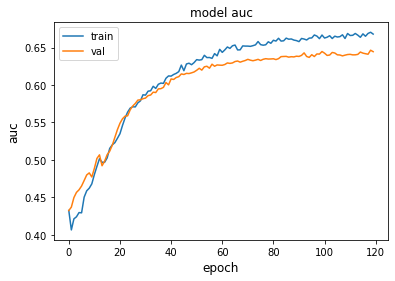

In [22]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 0s 656us/step


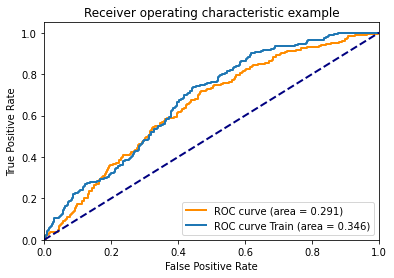

In [23]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [24]:
growth_train

array([[0.00089999],
       [0.00027221],
       [0.00020936],
       ...,
       [0.00069533],
       [0.00042494],
       [0.00015844]])

In [25]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Train Results is:{results.sum()}')

155/155 [==============================] - 0s 602us/step
Train Results is:-1.8794190089594611


In [26]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:-2.167887119960243


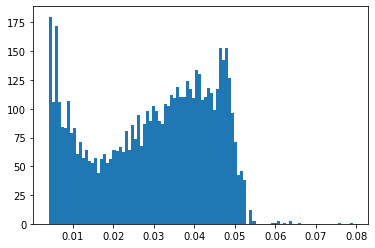

In [27]:
plt.hist(train_predictions,bins=100)
plt.show()

## 2.0 1D Convolutional NN

In [27]:
model = keras.Sequential([
    keras.layers.Conv1D(36,2,
                        activation='sigmoid',
                        input_shape=(X_train.shape[1],X_train.shape[2]),padding="valid",groups=1,
                        kernel_regularizer=tf.keras.regularizers.l2(l=.05)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [28]:
metrics = [
    tf.metrics.AUC(name='auc')
]

#odel.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [29]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [30]:
history = model.fit(X_train,y_train,batch_size=50,epochs=200,verbose=2,validation_data=(X_test,y_test))

Epoch 1/200
120/120 - 1s - loss: 0.8177 - auc: 0.5315 - val_loss: 0.7394 - val_auc: 0.5360 - 1s/epoch - 9ms/step
Epoch 2/200
120/120 - 0s - loss: 0.6721 - auc: 0.5288 - val_loss: 0.6277 - val_auc: 0.5854 - 291ms/epoch - 2ms/step
Epoch 3/200
120/120 - 0s - loss: 0.5725 - auc: 0.5922 - val_loss: 0.5516 - val_auc: 0.5825 - 306ms/epoch - 3ms/step
Epoch 4/200
120/120 - 0s - loss: 0.5021 - auc: 0.6230 - val_loss: 0.4892 - val_auc: 0.5821 - 294ms/epoch - 2ms/step
Epoch 5/200
120/120 - 0s - loss: 0.4484 - auc: 0.6154 - val_loss: 0.4401 - val_auc: 0.5878 - 295ms/epoch - 2ms/step
Epoch 6/200
120/120 - 0s - loss: 0.4050 - auc: 0.6201 - val_loss: 0.4005 - val_auc: 0.5952 - 286ms/epoch - 2ms/step
Epoch 7/200
120/120 - 0s - loss: 0.3683 - auc: 0.6383 - val_loss: 0.3673 - val_auc: 0.5886 - 297ms/epoch - 2ms/step
Epoch 8/200
120/120 - 0s - loss: 0.3369 - auc: 0.6459 - val_loss: 0.3388 - val_auc: 0.5923 - 280ms/epoch - 2ms/step
Epoch 9/200
120/120 - 0s - loss: 0.3098 - auc: 0.6489 - val_loss: 0.3141 - 

Epoch 72/200
120/120 - 0s - loss: 0.1327 - auc: 0.6582 - val_loss: 0.1561 - val_auc: 0.6546 - 309ms/epoch - 3ms/step
Epoch 73/200
120/120 - 0s - loss: 0.1326 - auc: 0.6539 - val_loss: 0.1555 - val_auc: 0.6568 - 324ms/epoch - 3ms/step
Epoch 74/200
120/120 - 0s - loss: 0.1329 - auc: 0.6438 - val_loss: 0.1559 - val_auc: 0.6523 - 317ms/epoch - 3ms/step
Epoch 75/200
120/120 - 0s - loss: 0.1322 - auc: 0.6570 - val_loss: 0.1553 - val_auc: 0.6556 - 318ms/epoch - 3ms/step
Epoch 76/200
120/120 - 0s - loss: 0.1321 - auc: 0.6661 - val_loss: 0.1565 - val_auc: 0.6591 - 315ms/epoch - 3ms/step
Epoch 77/200
120/120 - 0s - loss: 0.1322 - auc: 0.6641 - val_loss: 0.1551 - val_auc: 0.6557 - 301ms/epoch - 3ms/step
Epoch 78/200
120/120 - 0s - loss: 0.1325 - auc: 0.6480 - val_loss: 0.1560 - val_auc: 0.6577 - 310ms/epoch - 3ms/step
Epoch 79/200
120/120 - 0s - loss: 0.1322 - auc: 0.6587 - val_loss: 0.1570 - val_auc: 0.6544 - 318ms/epoch - 3ms/step
Epoch 80/200
120/120 - 0s - loss: 0.1323 - auc: 0.6588 - val_los

Epoch 142/200
120/120 - 0s - loss: 0.1312 - auc: 0.6696 - val_loss: 0.1546 - val_auc: 0.6661 - 305ms/epoch - 3ms/step
Epoch 143/200
120/120 - 0s - loss: 0.1307 - auc: 0.6812 - val_loss: 0.1549 - val_auc: 0.6639 - 313ms/epoch - 3ms/step
Epoch 144/200
120/120 - 0s - loss: 0.1309 - auc: 0.6771 - val_loss: 0.1546 - val_auc: 0.6663 - 329ms/epoch - 3ms/step
Epoch 145/200
120/120 - 0s - loss: 0.1313 - auc: 0.6641 - val_loss: 0.1547 - val_auc: 0.6673 - 313ms/epoch - 3ms/step
Epoch 146/200
120/120 - 0s - loss: 0.1307 - auc: 0.6772 - val_loss: 0.1544 - val_auc: 0.6616 - 313ms/epoch - 3ms/step
Epoch 147/200
120/120 - 0s - loss: 0.1307 - auc: 0.6773 - val_loss: 0.1556 - val_auc: 0.6661 - 305ms/epoch - 3ms/step
Epoch 148/200
120/120 - 0s - loss: 0.1312 - auc: 0.6704 - val_loss: 0.1554 - val_auc: 0.6665 - 312ms/epoch - 3ms/step
Epoch 149/200
120/120 - 0s - loss: 0.1309 - auc: 0.6721 - val_loss: 0.1550 - val_auc: 0.6610 - 375ms/epoch - 3ms/step
Epoch 150/200
120/120 - 0s - loss: 0.1313 - auc: 0.6694 

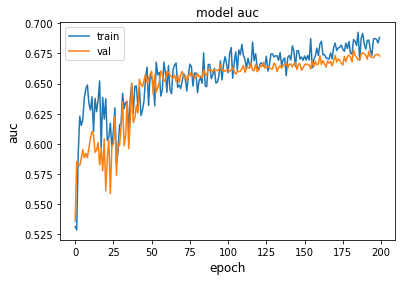

In [31]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 0s 1ms/step


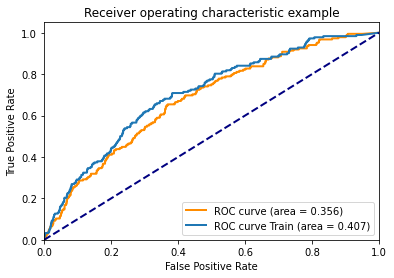

In [32]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [33]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 0s 1ms/step
Results is:-8.360555389481405


In [34]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:4.0936382094406305


Tops out at 0.35....

## 3.0 LTSM
Not even sure this is right..

In [60]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras

lookback = 20
model = keras.Sequential([
    keras.layers.LSTM(20,input_shape=(21,5)),
    keras.layers.Dense(5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [61]:
import tensorflow as tf

metrics = [tf.metrics.AUC(name='auc')]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
120/120 - 2s - loss: 0.6319 - auc: 0.4702 - val_loss: 0.4982 - val_auc: 0.3829 - 2s/epoch - 19ms/step
Epoch 2/100
120/120 - 1s - loss: 0.3853 - auc: 0.4149 - val_loss: 0.2987 - val_auc: 0.4364 - 630ms/epoch - 5ms/step
Epoch 3/100
120/120 - 1s - loss: 0.2330 - auc: 0.4290 - val_loss: 0.2039 - val_auc: 0.4555 - 608ms/epoch - 5ms/step
Epoch 4/100
120/120 - 1s - loss: 0.1696 - auc: 0.4467 - val_loss: 0.1742 - val_auc: 0.4608 - 592ms/epoch - 5ms/step
Epoch 5/100
120/120 - 1s - loss: 0.1504 - auc: 0.4264 - val_loss: 0.1673 - val_auc: 0.4523 - 615ms/epoch - 5ms/step
Epoch 6/100
120/120 - 1s - loss: 0.1445 - auc: 0.4308 - val_loss: 0.1652 - val_auc: 0.4767 - 615ms/epoch - 5ms/step
Epoch 7/100
120/120 - 1s - loss: 0.1420 - auc: 0.4294 - val_loss: 0.1642 - val_auc: 0.4635 - 663ms/epoch - 6ms/step
Epoch 8/100
120/120 - 1s - loss: 0.1406 - auc: 0.4649 - val_loss: 0.1636 - val_auc: 0.4875 - 632ms/epoch - 5ms/step
Epoch 9/100
120/120 - 1s - loss: 0.1396 - auc: 0.5002 - val_loss: 0.1629 -

Epoch 72/100
120/120 - 1s - loss: 0.1317 - auc: 0.6439 - val_loss: 0.1554 - val_auc: 0.6535 - 586ms/epoch - 5ms/step
Epoch 73/100
120/120 - 1s - loss: 0.1318 - auc: 0.6352 - val_loss: 0.1561 - val_auc: 0.6541 - 587ms/epoch - 5ms/step
Epoch 74/100
120/120 - 1s - loss: 0.1316 - auc: 0.6407 - val_loss: 0.1555 - val_auc: 0.6559 - 589ms/epoch - 5ms/step
Epoch 75/100
120/120 - 1s - loss: 0.1316 - auc: 0.6377 - val_loss: 0.1547 - val_auc: 0.6535 - 587ms/epoch - 5ms/step
Epoch 76/100
120/120 - 1s - loss: 0.1317 - auc: 0.6368 - val_loss: 0.1545 - val_auc: 0.6563 - 587ms/epoch - 5ms/step
Epoch 77/100
120/120 - 1s - loss: 0.1316 - auc: 0.6432 - val_loss: 0.1550 - val_auc: 0.6591 - 584ms/epoch - 5ms/step
Epoch 78/100
120/120 - 1s - loss: 0.1315 - auc: 0.6440 - val_loss: 0.1554 - val_auc: 0.6565 - 585ms/epoch - 5ms/step
Epoch 79/100
120/120 - 1s - loss: 0.1315 - auc: 0.6376 - val_loss: 0.1554 - val_auc: 0.6561 - 587ms/epoch - 5ms/step
Epoch 80/100
120/120 - 1s - loss: 0.1314 - auc: 0.6477 - val_los

In [62]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [63]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
120/120 - 1s - loss: 0.1308 - auc: 0.6553 - val_loss: 0.1549 - val_auc: 0.6660 - 622ms/epoch - 5ms/step
Epoch 2/100
120/120 - 1s - loss: 0.1306 - auc: 0.6613 - val_loss: 0.1545 - val_auc: 0.6719 - 600ms/epoch - 5ms/step
Epoch 3/100
120/120 - 1s - loss: 0.1304 - auc: 0.6653 - val_loss: 0.1542 - val_auc: 0.6701 - 626ms/epoch - 5ms/step
Epoch 4/100
120/120 - 1s - loss: 0.1301 - auc: 0.6828 - val_loss: 0.1560 - val_auc: 0.6703 - 640ms/epoch - 5ms/step
Epoch 5/100
120/120 - 1s - loss: 0.1305 - auc: 0.6606 - val_loss: 0.1539 - val_auc: 0.6659 - 640ms/epoch - 5ms/step
Epoch 6/100
120/120 - 1s - loss: 0.1304 - auc: 0.6669 - val_loss: 0.1548 - val_auc: 0.6662 - 612ms/epoch - 5ms/step
Epoch 7/100
120/120 - 1s - loss: 0.1301 - auc: 0.6702 - val_loss: 0.1543 - val_auc: 0.6707 - 588ms/epoch - 5ms/step
Epoch 8/100
120/120 - 1s - loss: 0.1302 - auc: 0.6649 - val_loss: 0.1537 - val_auc: 0.6641 - 594ms/epoch - 5ms/step
Epoch 9/100
120/120 - 1s - loss: 0.1301 - auc: 0.6740 - val_loss: 0.1540

120/120 - 1s - loss: 0.1272 - auc: 0.7121 - val_loss: 0.1564 - val_auc: 0.6595 - 589ms/epoch - 5ms/step
Epoch 72/100
120/120 - 1s - loss: 0.1275 - auc: 0.7124 - val_loss: 0.1551 - val_auc: 0.6568 - 610ms/epoch - 5ms/step
Epoch 73/100
120/120 - 1s - loss: 0.1274 - auc: 0.7094 - val_loss: 0.1569 - val_auc: 0.6573 - 628ms/epoch - 5ms/step
Epoch 74/100
120/120 - 1s - loss: 0.1272 - auc: 0.7182 - val_loss: 0.1555 - val_auc: 0.6575 - 637ms/epoch - 5ms/step
Epoch 75/100
120/120 - 1s - loss: 0.1272 - auc: 0.7125 - val_loss: 0.1554 - val_auc: 0.6521 - 619ms/epoch - 5ms/step
Epoch 76/100
120/120 - 1s - loss: 0.1271 - auc: 0.7218 - val_loss: 0.1554 - val_auc: 0.6527 - 601ms/epoch - 5ms/step
Epoch 77/100
120/120 - 1s - loss: 0.1271 - auc: 0.7185 - val_loss: 0.1554 - val_auc: 0.6599 - 593ms/epoch - 5ms/step
Epoch 78/100
120/120 - 1s - loss: 0.1269 - auc: 0.7243 - val_loss: 0.1560 - val_auc: 0.6571 - 635ms/epoch - 5ms/step
Epoch 79/100
120/120 - 1s - loss: 0.1273 - auc: 0.7105 - val_loss: 0.1555 - v

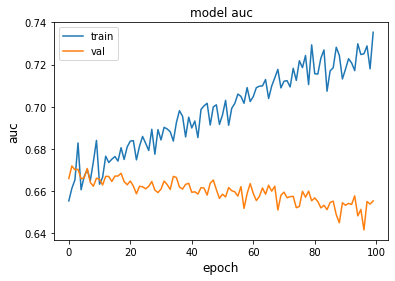

In [64]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 0s 2ms/step


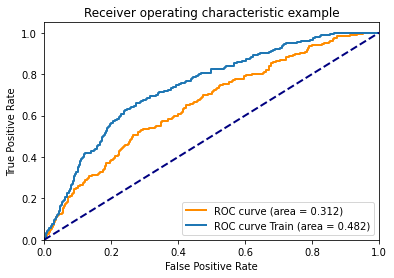

In [65]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [66]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 0s 2ms/step
Results is:13.198485954922422


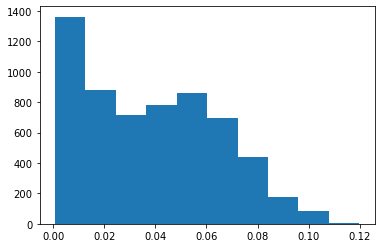

In [67]:
plt.hist(train_predictions)
plt.show()

## 4.0 Conv2D non-color image (i.e. close only)
The image is essentialy the plot of the highs, lows, close, and open. Need to do some manipulation here.

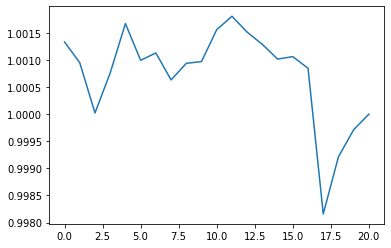

In [40]:
plt.plot(X_train[-1,:,1])
plt.show()

In [41]:
levels = np.arange(0.996,1.001,0.0001)
levels = [-np.inf]+levels.tolist()+[np.inf]
n_levels = len(levels)
labels = np.arange(n_levels-1)

Y = pd.cut(X_train[0,:,1],levels,labels=labels[::-1])

y_resolution = len(levels)
X = np.arange(0,len(X_train[0,:,1]))

blank = np.zeros( (n_levels,21))
for n,(x,y) in enumerate(zip(X,Y)):
    blank[y,x] = X_train[0,:,1][n]

In [42]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    series = series.ravel()
    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)
    Y = pd.cut(series,levels,labels=labels[::-1])
    
    y_resolution = len(levels)
    X = np.arange(0,len(series))
    
    blank = np.zeros( (n_levels,21))
    for n,(x,y) in enumerate(zip(X,Y)):
        #blank[y,x] = series[n]
        blank[y,x] = 255
        
    return blank

In [43]:
def plot_time_series(series):
    np_img = convert_time_series_img(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [46]:
convert_time_series_img(X_train[0,:,1],0.994,1.006,0.0001).shape

(123, 21)

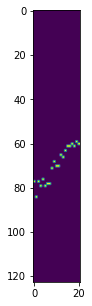

In [44]:
plot_time_series(X_train[0,:,1])

In [76]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,1],0.98,1.02,0.0001) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

Hoooooo-rah!!!! Looks like its working.

![SegmentLocal](array.gif "segment")

In [77]:
img_train = np.stack([convert_time_series_img(X_train[x,:,1],0.99,1.01,0.0001).reshape(203,21,1) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,1],0.99,1.01,0.0001).reshape(203,21,1) for x in range(len(X_test))])

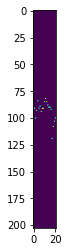

In [78]:
plt.imshow(img_train[-1])

In [79]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 201, 19, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 67, 9, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 7, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 3, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 1, 32)         18464     
                                                                 
 flatten_3 (Flatten)         (None, 608)              

In [80]:
batch_size = 200
epochs = 30

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/30
30/30 [==============================] - 7s 211ms/step - loss: 4.7274 - auc: 0.5165 - val_loss: 0.3743 - val_auc: 0.4943
Epoch 2/30
30/30 [==============================] - 6s 203ms/step - loss: 1.5362 - auc: 0.5132 - val_loss: 0.2893 - val_auc: 0.4995
Epoch 3/30
30/30 [==============================] - 6s 190ms/step - loss: 1.1243 - auc: 0.4943 - val_loss: 0.2253 - val_auc: 0.4775
Epoch 4/30
30/30 [==============================] - 6s 189ms/step - loss: 0.8589 - auc: 0.4736 - val_loss: 0.2120 - val_auc: 0.4703
Epoch 5/30
30/30 [==============================] - 6s 189ms/step - loss: 0.7274 - auc: 0.4740 - val_loss: 0.2035 - val_auc: 0.4794
Epoch 6/30
30/30 [==============================] - 6s 194ms/step - loss: 0.6296 - auc: 0.4927 - val_loss: 0.1996 - val_auc: 0.4819
Epoch 7/30
30/30 [==============================] - 6s 192ms/step - loss: 0.5944 - auc: 0.4786 - val_loss: 0.1957 - val_auc: 0.4801
Epoch 8/30
30/30 [==============================] - 6s 192ms/step - loss: 0.

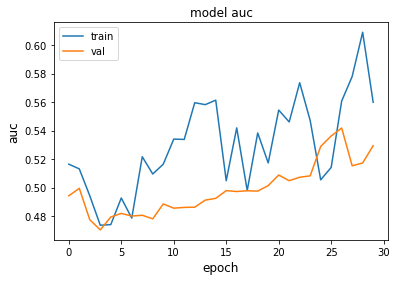

In [81]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 9ms/step


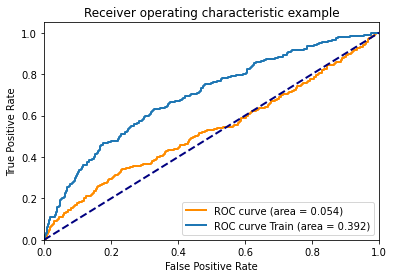

In [82]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [83]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 1s 9ms/step
Results is:9.953793706755054


In [84]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:11.482582701004317


The probability distribution looks nice!!!

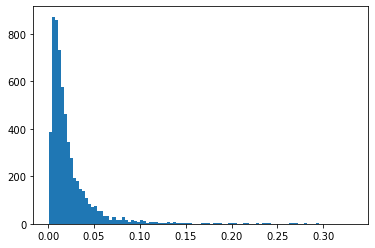

In [85]:
plt.hist(train_predictions,bins=100)
plt.show()

In [87]:
for n,v in enumerate(train_predictions):
    if v>0.3:
        print(n)

3022
3745
5515


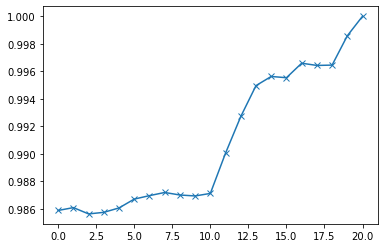

In [97]:
plt.plot(X_train[3022,:,1],marker='x')

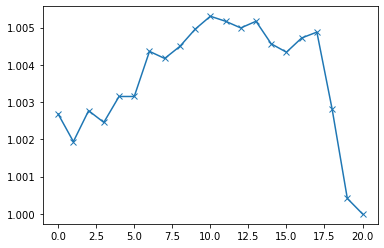

In [99]:
plt.plot(X_train[3745,:,1],marker='x')

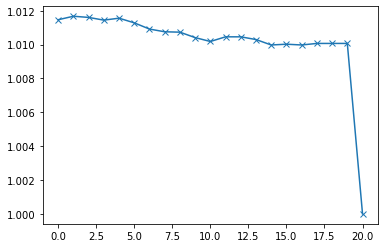

In [100]:
plt.plot(X_train[5515,:,1],marker='x')

## 5.0 Conv2D with color (still no volume)

In [68]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

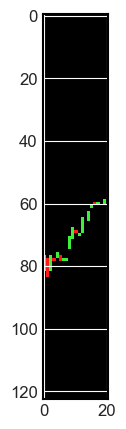

In [69]:
plot_time_series(X_train[0,:,:])

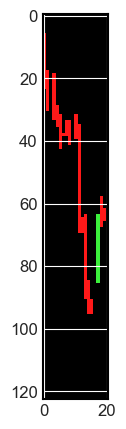

In [70]:
plot_time_series(X_train[1200,:,:])

Just checking that the color of the candles looks right - appears to be...

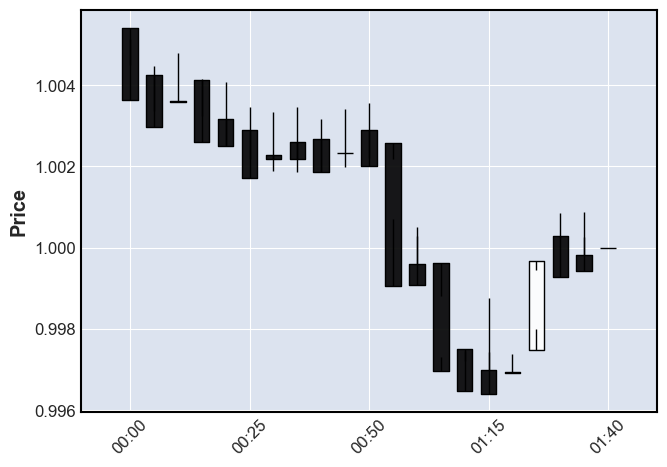

In [71]:
import mplfinance as mpf
intervals = pd.DataFrame(X_train[1200,:,:],columns=['volume','close','open','high','low'])
intervals.index = pd.date_range('2021-06-01',periods=len(intervals.index),freq='5min')
mpf.plot(intervals,type='candle')

Creating a pretty gif so i can show off.

In [72]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [73]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])

In [74]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 3)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 201, 19, 32)       896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 67, 9, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 7, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 3, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 1, 32)         18464     
                                                                 
 flatten_2 (Flatten)         (None, 608)              

In [83]:
batch_size = 200
epochs = 20

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/20
30/30 [==============================] - 8s 250ms/step - loss: 0.1703 - auc: 0.6431 - val_loss: 0.1679 - val_auc: 0.6163
Epoch 2/20
30/30 [==============================] - 7s 244ms/step - loss: 0.1595 - auc: 0.6531 - val_loss: 0.1694 - val_auc: 0.6186
Epoch 3/20
30/30 [==============================] - 7s 237ms/step - loss: 0.1536 - auc: 0.6642 - val_loss: 0.1761 - val_auc: 0.6167
Epoch 4/20
30/30 [==============================] - 7s 238ms/step - loss: 0.1514 - auc: 0.6743 - val_loss: 0.1788 - val_auc: 0.6164
Epoch 5/20
30/30 [==============================] - 7s 236ms/step - loss: 0.1490 - auc: 0.6805 - val_loss: 0.1666 - val_auc: 0.6296
Epoch 6/20
30/30 [==============================] - 7s 241ms/step - loss: 0.1480 - auc: 0.6825 - val_loss: 0.1738 - val_auc: 0.6016
Epoch 7/20
30/30 [==============================] - 8s 256ms/step - loss: 0.1465 - auc: 0.6810 - val_loss: 0.1636 - val_auc: 0.6302
Epoch 8/20
30/30 [==============================] - 7s 244ms/step - loss: 0.

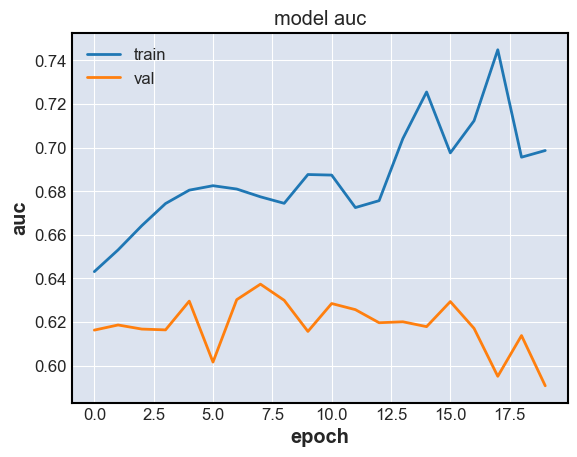

In [84]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 12ms/step


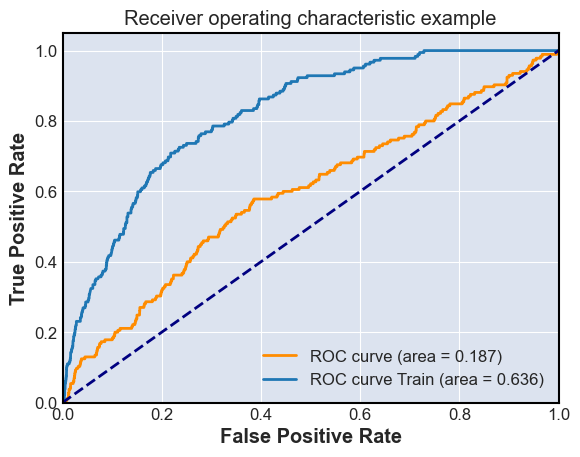

In [85]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [86]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 2s 12ms/step
Results is:29.50398665886871


In [87]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:5.790924973119361


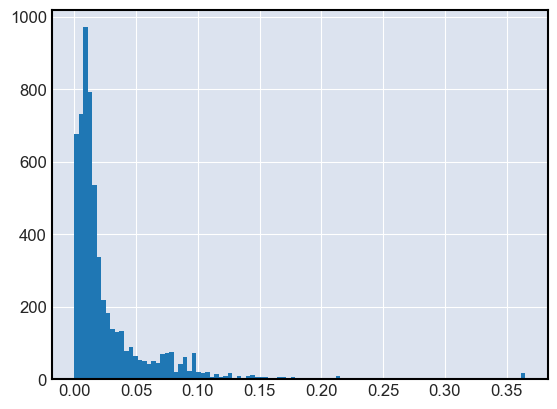

In [88]:
plt.hist(train_predictions,bins=100)
plt.show()

###### running a simulation

## 6.0 Conv2D with color with highs and lows (still no volume)

In [123]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.99,1.01,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [120]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [124]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])

In [125]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 3)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 201, 19, 32)       896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 67, 9, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 65, 7, 64)         18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 3, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 19, 1, 32)         18464     
                                                                 
 flatten_3 (Flatten)         (None, 608)              

In [126]:
batch_size = 200
epochs = 20

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/20
30/30 [==============================] - 9s 272ms/step - loss: 2.2566 - auc: 0.5102 - val_loss: 0.3147 - val_auc: 0.5084
Epoch 2/20
30/30 [==============================] - 8s 261ms/step - loss: 0.4958 - auc: 0.5283 - val_loss: 0.2215 - val_auc: 0.5078
Epoch 3/20
30/30 [==============================] - 8s 263ms/step - loss: 0.3906 - auc: 0.5627 - val_loss: 0.1863 - val_auc: 0.5281
Epoch 4/20
30/30 [==============================] - 8s 252ms/step - loss: 0.3348 - auc: 0.5699 - val_loss: 0.1813 - val_auc: 0.5492
Epoch 5/20
30/30 [==============================] - 7s 246ms/step - loss: 0.2721 - auc: 0.5676 - val_loss: 0.2728 - val_auc: 0.5443
Epoch 6/20
30/30 [==============================] - 8s 260ms/step - loss: 0.2323 - auc: 0.5950 - val_loss: 0.1641 - val_auc: 0.6187
Epoch 7/20
30/30 [==============================] - 7s 251ms/step - loss: 0.1872 - auc: 0.6613 - val_loss: 0.1603 - val_auc: 0.6270
Epoch 8/20
30/30 [==============================] - 7s 244ms/step - loss: 0.

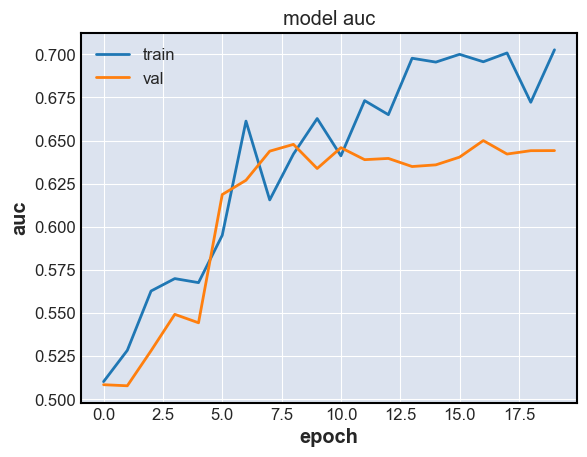

In [127]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

188/188 [==============================] - 2s 11ms/step


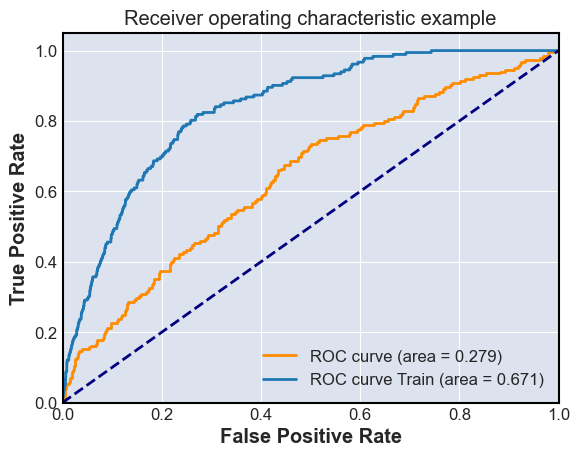

In [128]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [129]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

155/155 [==============================] - 2s 11ms/step
Results is:35.985603116608445


In [130]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:15.727571289799748


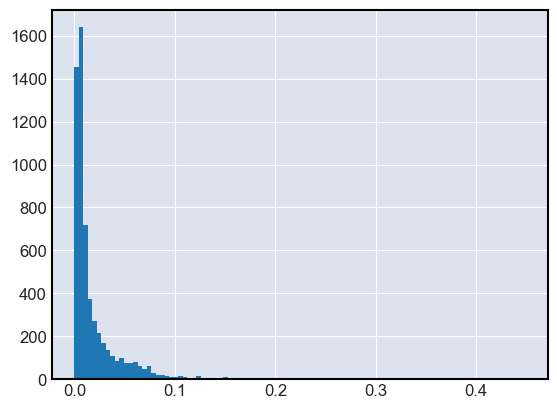

In [132]:
plt.hist(train_predictions,bins=100)
plt.show()

## 6.0 Conv2D with color with highs and lows and Volume

Here the model is of the same architecture, albeit the volume is concatenated onto the output of the convolution encoding layers. This means volume is simply a time series.

Other features can be added in this way, such as RSI or moving averages.